<a href="https://colab.research.google.com/github/sobti/TSAI/blob/master/Cars/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import argparse
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch
from google.colab import drive
import os
import sys
drive.mount('/content/gdrive/')
os.makedirs("images_mnist", exist_ok=True)

Mounted at /content/gdrive/


In [ ]:
os.makedirs("images_mnistp", exist_ok=True)

In [2]:
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/')
os.chdir('/content/gdrive/My Drive/Colab Notebooks')

In [3]:
!7z x '/content/gdrive/My Drive/Colab Notebooks/red_cars.7z' -o'/content/data/'


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/gdrive/My Drive/Colab Notebooks/                                                   1 file, 3581431 bytes (3498 KiB)

Extracting archive: /content/gdrive/My Drive/Colab Notebooks/red_cars.7z
--
Path = /content/gdrive/My Drive/Colab Notebooks/red_cars.7z
Type = 7z
Physical Size = 3581431
Headers Size = 13842
Method = LZMA2:6m
Solid = +
Blocks = 1

  0%     87% 1       87% 877 - red_cars/car_0876.jpg                                 87% 1323 - red_cars/car_1322.jpg                                 

In [4]:
input=[]
label=[]
import numpy as np
from PIL import Image

count=1  # to restrict the data to few thousand


# Getting the BG list and replicate each background to 4000 


for root_cars, dirs_cars, files_cars in os.walk("/content/data/red_cars"):
   for cars in files_cars:
     check_for_Jpg=cars.split('.')
     if check_for_Jpg[-1].lower()=='jpg' or check_for_Jpg[-1].lower() =='jpeg':
      
        p= Image.open(root_cars +'/'+ cars)
        if p.mode == 'RGB':
         
         input.append(root_cars +'/'+ cars)

In [ ]:
input

['/content/data/red_cars/car_0142.jpg',
 '/content/data/red_cars/car_0382.jpg',
 '/content/data/red_cars/car_1224.jpg',
 '/content/data/red_cars/car_0952.jpg',
 '/content/data/red_cars/car_1234.jpg',
 '/content/data/red_cars/car_1299.jpg',
 '/content/data/red_cars/car_0459.jpg',
 '/content/data/red_cars/car_0284.jpg',
 '/content/data/red_cars/car_0107.jpg',
 '/content/data/red_cars/car_0042.jpg',
 '/content/data/red_cars/car_0861.jpg',
 '/content/data/red_cars/car_0486.jpg',
 '/content/data/red_cars/car_0989.jpg',
 '/content/data/red_cars/car_1000.jpg',
 '/content/data/red_cars/car_1033.jpg',
 '/content/data/red_cars/car_0721.jpg',
 '/content/data/red_cars/car_0026.jpg',
 '/content/data/red_cars/car_0970.jpg',
 '/content/data/red_cars/car_1419.jpg',
 '/content/data/red_cars/car_0050.jpg',
 '/content/data/red_cars/car_0215.jpg',
 '/content/data/red_cars/car_1136.jpg',
 '/content/data/red_cars/car_0705.jpg',
 '/content/data/red_cars/car_1083.jpg',
 '/content/data/red_cars/car_0350.jpg',


In [5]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = 100 // 4
        self.l1 = nn.Sequential(nn.Linear(100, 128 * self.init_size ** 2)) # Latent dimension

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            #nn.BatchNorm2d(128),
            nn.BatchNorm2d(128, 0.8),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            #nn.BatchNorm2d(64, 0.8),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64,3, 3, stride=1, padding=1),
            nn.Tanh(),
        )
    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(3, 16, bn=False), #channels
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = 100 // 2 ** 4
        #self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())
        self.adv_layer = nn.Sequential(nn.Linear(6272, 1), nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        #print(out.shape)
        out = out.view(out.shape[0], -1)
        #print(out.shape,128 * (28 // 2 ** 4) ** 2, 1)
        validity = self.adv_layer(out)

        return validity


In [8]:
# Loss function
adversarial_loss = torch.nn.BCELoss()

In [9]:
 # Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

generator.to('cuda')
discriminator.to('cuda')
adversarial_loss.to('cuda')

# Initialize weights
discriminator.apply(weights_init_normal)
generator.apply(weights_init_normal)


Generator(
  (l1): Sequential(
    (0): Linear(in_features=100, out_features=80000, bias=True)
  )
  (conv_blocks): Sequential(
    (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode=nearest)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Upsample(scale_factor=2.0, mode=nearest)
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Tanh()
  )
)

In [10]:
transform=transforms.Compose(
            [transforms.Resize((100,100)), transforms.ToTensor()])

In [11]:
from PIL import Image
class Myclass(torch.utils.data.Dataset):
    def __init__ (self,dataset,transform=None):
       #super(depthmask, self).__init__()
       self.dataset = dataset
       self.transform = transform
       

    def __getitem__ (self, idx): 
         out_dataset = Image.open(self.dataset[idx])
         if self.transform:
           out_dataset = self.transform(out_dataset)
           sample = {'images' : out_dataset }
         return sample
    
    def __len__ (self):
       return len(self.dataset)

In [12]:
train_dataset=Myclass(input,transform=transform)
for i in range(len(train_dataset)):
    sample = train_dataset[i]
    print(i,'-images-train:', sample['images'].size())

    if i == 3:
        break


0 -images-train: torch.Size([3, 100, 100])
1 -images-train: torch.Size([3, 100, 100])
2 -images-train: torch.Size([3, 100, 100])
3 -images-train: torch.Size([3, 100, 100])


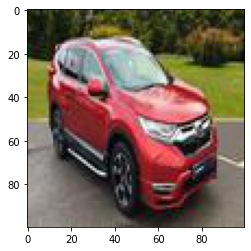

In [13]:
import numpy as np
import matplotlib.pyplot as plt
plt.imshow((np.transpose((sample['images'].cpu().detach().numpy()),(1,2,0))))


In [ ]:
#os.makedirs("../../data/mnist", exist_ok=True)
#dataloader = torch.utils.data.DataLoader(
#    datasets.MNIST(
#        "../../data/mnist",
#        train=True,
#        download=True,
#        transform=transforms.Compose(
#            [transforms.Resize(28), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
#        ),
#    ),
#    batch_size=64,
#    shuffle=True,
#)

In [14]:
SEED = 1
torch.cuda.empty_cache()
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
torch.manual_seed(SEED)
if cuda:
  torch.cuda.manual_seed(SEED) 
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128,
                                          shuffle=True, num_workers=2)

CUDA Available? True


In [15]:
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.001, betas=(0.9,0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.9,0.999))

Tensor = torch.cuda.FloatTensor if 'cuda' else torch.FloatTensor


In [16]:
for epoch in range(3000):
    for i, (imgs) in enumerate(dataloader):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs['images'].shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs['images'].shape[0], 1).fill_(0.0), requires_grad=False)
        # Configure input
        real_imgs = Variable(imgs['images'].type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        
        z = Variable(Tensor(np.random.normal(0, 1, (imgs['images'].shape[0], 100))))

        # Generate a batch of images
        gen_imgs = generator(z)
        #print(gen_imgs.shape)
        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()
        #print(real_imgs.shape)
        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, 20, i, len(dataloader), d_loss.item(), g_loss.item())
        )

        batches_done = epoch * len(dataloader) + i
        if batches_done % 5 == 0 and epoch % 99 == 0:
            save_image(gen_imgs.data[:10], "/content/images_mnist/%d.png" % batches_done, nrow=5, normalize=True)

Streaming output truncated to the last 5000 lines.
[Epoch 2583/20] [Batch 5/12] [D loss: 0.311079] [G loss: 2.204065]
[Epoch 2583/20] [Batch 6/12] [D loss: 0.573518] [G loss: 1.212743]
[Epoch 2583/20] [Batch 7/12] [D loss: 0.546733] [G loss: 1.268839]
[Epoch 2583/20] [Batch 8/12] [D loss: 0.550794] [G loss: 1.198895]
[Epoch 2583/20] [Batch 9/12] [D loss: 0.671228] [G loss: 1.243929]
[Epoch 2583/20] [Batch 10/12] [D loss: 0.772278] [G loss: 1.369895]
[Epoch 2583/20] [Batch 11/12] [D loss: 0.609461] [G loss: 2.127777]
[Epoch 2584/20] [Batch 0/12] [D loss: 0.393243] [G loss: 2.069015]
[Epoch 2584/20] [Batch 1/12] [D loss: 0.384532] [G loss: 1.097256]
[Epoch 2584/20] [Batch 2/12] [D loss: 0.441998] [G loss: 1.618990]
[Epoch 2584/20] [Batch 3/12] [D loss: 0.382160] [G loss: 1.320755]
[Epoch 2584/20] [Batch 4/12] [D loss: 0.277750] [G loss: 1.273192]
[Epoch 2584/20] [Batch 5/12] [D loss: 0.451392] [G loss: 1.178913]
[Epoch 2584/20] [Batch 6/12] [D loss: 0.297907] [G loss: 2.476030]
[Epoch 25

In [ ]:
save_image(gen_imgs.data[:100], "/content/images_mnist/final.png", nrow=10, normalize=True)

In [24]:
import shutil 
shutil.copytree('/content/images_mnist', '/content/gdrive/My Drive/Colab Notebooks/logs') 

'/content/gdrive/My Drive/Colab Notebooks/logs'